In [1]:
import os
os.chdir('..')


from util import CONFIG
CONFIG.set_use_mpl_tables(True)

## Section 6.2

Listing 6.1

In [2]:
from sim_circuit import QuantumRegister, QuantumCircuit

def geometric_sequence_circuit(n, theta):

    N = 2**n

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n): # <1>
        qc.h(q[j])

    for j in range(n): # <1>
        qc.p(2 ** j * theta, q[j])

    return qc

### Section 6.2.1

Listing 6.2

In [3]:
from math import pi

def encode_frequency(n, v):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])

    for j in range(n):
        qc.p(2 * pi / 2 ** (n - j) * v, q[j]) # <1>

    qc.report('geometric_sequence')

    qc.iqft(range(n))

    qc.report('iqft')

    return qc

### Section 6.2.2

In [4]:
n = 3
v = 4.3
qc = encode_frequency(n, v)
state = qc.run()

In [5]:
def prod(iterable):
    p = 1
    for n in iterable:
        p *= n
    return p

In [6]:
from math import cos
from util import all_close

N = 2**n
assert all_close([abs(state[k]) for k in range(N)], [
    abs(prod(cos((v - k) * pi / 2 ** (m + 1)) for m in range(n))) for k in
    range(N)])

In [7]:
from util import cis

def complex_sincd(n, v):
    N = 2 ** n
    return [prod(
        cos((v - k) * pi / 2 ** (j + 1)) * cis((v - k) * pi / 2 ** (j + 1))
        for j in range(n)) for k in range(2 ** n)]

In [8]:
assert all_close(state, complex_sincd(3, 4.3))

In [9]:
def complex_sincd_combined_cis(n, v):
    N = 2 ** n
    return [prod(cos((v - k) * pi / 2 ** (m + 1)) for m in range(n)) * cis(
        (N - 1) / N * (v - k) * pi) for k in range(2 ** n)]

In [10]:
assert all_close(state, complex_sincd_combined_cis(3, 4.3))

### Section 6.2.3

Listing 6.3

In [11]:
def geom_alt(n, v):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])

    for j in range(n):
        qc.p(pi * 2 ** -j * v, q[j]) # <1>

    return qc

Listing 6.4

In [12]:
def encode_frequency_q_alt(n, v):
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    for j in range(n):
        qc.h(q[j])
        qc.p(pi * 2 ** -j * v, q[j])

    qc.report('signal')

    qc.iqft(range(n)[::-1], swap=False)

    qc.report('iqft')

    return qc

## Section 6.3

In [13]:
from util import is_close
from math import sin

def discrete_sinc_by_digit(n , v):

    probs = [_ for _ in range(2**n)]
    for l in range(2**n): # <1>
        s = bin(l)[2:].zfill(n)
        assert(len(s) == n)
        p = 1
        k = 0
        for m in range(n): # <2>
            if s[m] == '0':
                p *= cos((v - k)*pi/2**(m+1))**2
            else:
                p *= sin((v - k)*pi/2**(m+1))**2
                k += 2**m

        probs[k] = p

    return probs

In [14]:
n = 3
v = 4.7
probs = discrete_sinc_by_digit(n, v)
assert all_close(discrete_sinc_by_digit(n, v), [abs(a)**2 for a in complex_sincd(n, v)])

In [15]:
def recursive_discrete_sinc(n, v):
    if n == 1:
        return [cos(v*pi/2)**2, sin(v*pi/2)**2]

    p = recursive_discrete_sinc(n-1, v)

    return [p[k] * cos((v - k) * pi / 2 ** n) ** 2 for k in
            range(2 ** (n - 1))] + [p[k] * sin((v - k) * pi / 2 ** n) ** 2
                                    for k in range(2 ** (n - 1))]

In [16]:
import numpy as np

def discrete_sinc_coin_flips(n, v, count=10000):
    samples = []
    for _ in range(count):
        k = 0
        for m in range(n):
            flip = np.random.binomial(1, sin((v-k)*pi/2**(m+1))**2)
            k += flip*2**m

        samples.append(k)

    return samples

## Section 6.4

### Section 6.4.1

Listing 6.5

In [17]:
def raised_cosine(n, mu):
    N = 2 ** n
    assert (0 <= mu < 2 ** n)

    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    qc.h(q[n - 1])
    qc.p(-pi * mu / N * 2, q[n - 1])

    qc.report('fourier_coefficients')

    qc.qft(q[::-1], False) # <1>

    qc.report('qft')

    return qc

In [18]:
qc = raised_cosine(3, 3.25)
state = qc.run()

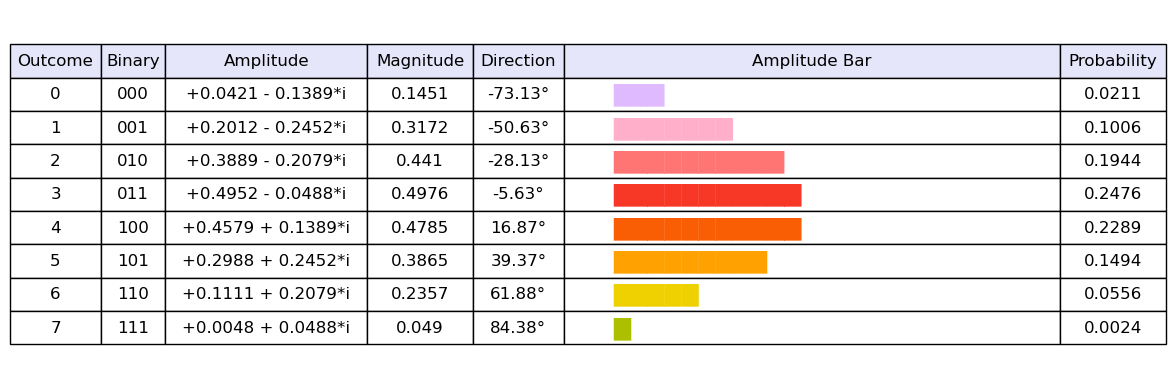

In [19]:
from util import show_state_table

show_state_table(state)

In [20]:
from math import sqrt

N = 8
mu = 3.25
a = [sqrt(2/N) * cos((k - mu)*pi/N) * cis((k-mu)*pi/N) for k in range(N)]
assert all_close(state, a)

In [21]:
s = N / 2
p = [1 / (2 * s) * (1 + cos((x - mu) / s * pi)) for x in range(N)]
p1 = [1 / s * cos((x - mu) / (2 * s) * pi) ** 2 for x in range(N)]

probs = [2/N*(cos((k - mu)*pi/N))**2 for k in range(N)] 

assert all_close(p, probs)
assert all_close(p1, probs)

### Section 6.4.2

Listing 6.6

In [22]:
from math import acos

def sin_4(n):
    theta = acos(sqrt(2 / 3))
    q = QuantumRegister(n)
    qc = QuantumCircuit(q)

    qc.ry(2 * theta, q[n - 1])
    qc.p(pi, q[n - 1])
    qc.cry(pi / 2, q[n - 1], q[0])

    for i in range(1, n - 1):
        qc.cx(q[0], q[i])

    qc.report('frequencies')

    qc.qft(q[::-1], False)

    qc.report('qft')

    return qc

In [23]:
n = 3           
N = 2 ** n      
qc = sin_4(n)   
state = qc.run()

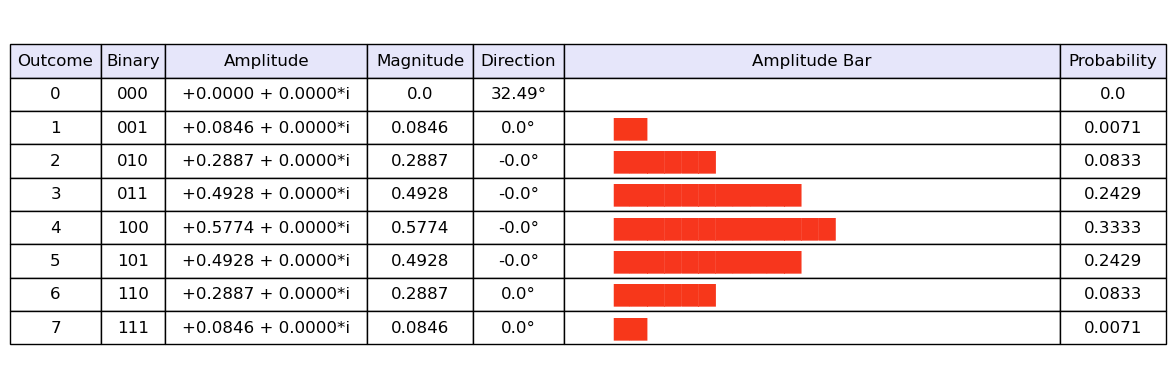

In [24]:
show_state_table(state)

In [25]:
s = [sqrt(8 / (3 * N)) * (sin(k * pi / N)) ** 2 for k in range(N)]
assert all_close(state, s)
p = [8 / 3 / N * (sin(k * pi / N)) ** 4 for k in range(N)] # <1>
assert all_close([abs(state[k])**2 for k in range(N)], p)